In [1]:
from IPython.display import display

from sympy.interactive import printing
printing.init_printing(use_latex=True)

from __future__ import division
import sympy as sym
from sympy import *

%matplotlib inline
from matplotlib import rc
import matplotlib.pyplot as plt
rc('font',**{'family':'serif','size'   : 12})

In [2]:
from qutip import *

# Several constants

In [3]:
from __future__ import division, print_function, unicode_literals

# Basic constants
pi = 3.1415926
c = 299792458
h = 6.62606957e-34
hbar = h / 2 / pi
k_B = 1.3806488e-23
m_e = 9.10938291e-31
m_p = 1.672621898e-27
mu_0 = 4e-7 * pi
epsilon_0 = 1 / c**2 / mu_0
E = 1.602176565e-19
N_A = 6.02214129e+23


# Mass of Sr-88, Sr-87, Sr-86, Sr-84
M88 = 1.459706905272492E-25  
M87 = 1.4431557366419E-25  
M86 = 1.42655671117996E-25
M84 = 1.3934150821E-25
M = M88

[ 0.85] [ 1.]
11.7159268856
[ 0.28  0.97  0.4   0.99  0.87] [ 0.33119857  0.5097353   0.36224844  0.51491028  0.48386041]
24.0643150806
[ 0.59  0.71  0.91  0.93  0.37  0.85  0.08  0.73  0.3   0.94] [ 0.30190025  0.32468517  0.36266004  0.36645753  0.26012788  0.35126758
  0.20506432  0.32848266  0.24683668  0.36835627]
38.0421199799
[ 0.66  0.95 -0.36  0.66  0.83  0.28  0.5   0.61  0.31  0.67 -0.09  0.7
 -0.65  0.11  0.97  0.26  0.67  0.54  0.81  0.47] [ 0.24691994  0.29005656  0.09519805  0.24691994  0.27220692  0.1903961
  0.22312043  0.23948259  0.19485851  0.24840741  0.13535973  0.25286982
  0.05206143  0.16510912  0.2930315   0.18742116  0.24840741  0.22907031
  0.26923198  0.21865802]
55.923304081


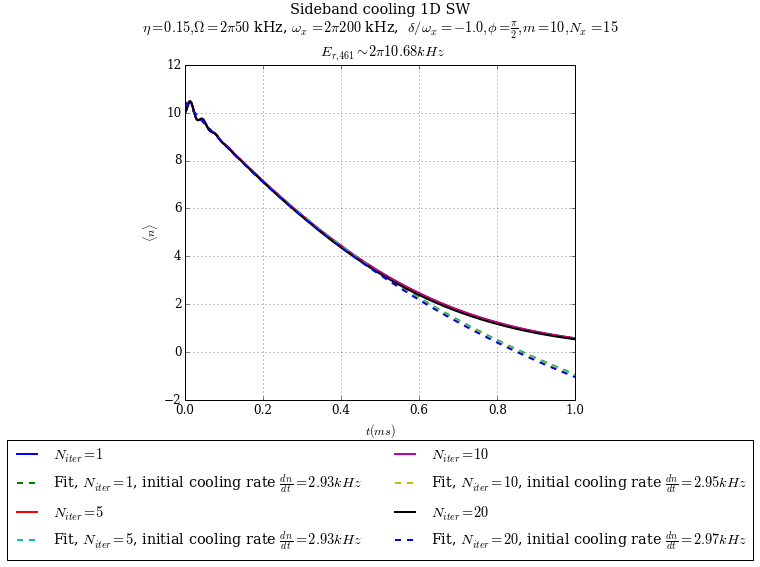

In [29]:
# For running wave the important parameter is the phase 
# Note that cooling can be extremely small for phi = 0 (antinode)
from scipy.optimize import curve_fit

def f(x, a, b, c):
    return a * exp(-2 * pi * b * x) + c 

import timeit
from numpy import linspace, arange, divide, sqrt, exp
from scipy import stats

Nx = 15   # Dimension of x-harmonic oscillator
m = 10
omega_x = 2* pi * 200   # In units of kHz
delta = -2 * pi * 200   # In units of kHz
omega = 2 * pi * 50     # In units of kHz
gamma = 2 * pi * 7      # In units of kHz
eta = 0.15
g = basis(2,0)          # Ground state
e = basis(2,1)          # Excited state
x = fock(Nx, m)         # x-harmonic oscillator
phi = 0.5 * pi

# Recoil energy of the blue
Recoil_461 = (hbar * 2 * pi / (461E-9)) ** 2 / (hbar * 2 * M88 * 1000)
#print(Recoil_461)

# Destruction operators in 1d
a_x = destroy(Nx)

# H_eff / hbar, otherwise too small, too many floats
# Now the two Hamiltonians give different result, I trust the second one
H = tensor(omega_x * (a_x.dag() * a_x + 0.5), qeye(2)) - tensor(qeye(Nx), 0.5 * delta * sigmaz()) + omega * 0.5 * (tensor((1j * eta * (a_x + a_x.dag())).expm() + (-1j * (eta * (a_x + a_x.dag()) + phi)).expm(), sigmap()) + tensor((-1j * eta * (a_x + a_x.dag())).expm() + (1j * (eta * (a_x + a_x.dag()) + phi)).expm(), sigmam()))
# H = tensor(omega_x * (a_x.dag() * a_x + 0.5), qeye(2)) - tensor(qeye(Nx), 0.5 * delta * sigmaz()) + omega * 0.5 * (tensor((1j * (eta * (a_x + a_x.dag()) + phi)).expm() + (-1j * (eta * (a_x + a_x.dag()) + phi)).expm(), sigmax()))

# Wavefunction in 1d, start from all in ground state
psi0 = tensor(x, g)

# Randomly generate u from dipole distribution
du = 0.01
u_ = arange(-1, 1, du)
p = [3 / 8 * (1 + u__) ** 2 for u__ in u_]
p = divide(p, sum(p))
dipole = stats.rv_discrete(name = 'custm', values = (range(len(p)), p))

dt = 1    # Time length
times = linspace(0.0, dt, 1000)
N_iter = [1, 5, 10, 20]
# N_iter = [1, 5]
# N_iter = [1]

import matplotlib.gridspec as gridspec
figure = plt.figure(figsize=(7, 6))
gs = gridspec.GridSpec(1, 1)
gs.update(wspace=0.3,hspace=0.4)
ax1 = plt.subplot(gs[0,0]) 
start = timeit.default_timer()

for N_iter_ in N_iter:
    idx = dipole.rvs(size = N_iter_)
    u = u_[idx]
    q = p[idx]
    q = divide(q, sum(q)) 
    q = sqrt(q)
    print(u, q)
    result = mesolve(H, psi0, times, [sqrt(gamma) * q[i] * tensor((1j * u[i] * eta * (a_x + a_x.dag())).expm(), sigmam()) for i in range(len(u))], [tensor(a_x.dag() * a_x, qeye(2))])
    ax1.plot(result.times, result.expect[0], label = '$N_{iter} = %d$' % (N_iter_), linewidth = 2, linestyle = '-');
    popt, pcov = curve_fit(f, result.times[: 500], result.expect[0][: 500])
    avg_fit = f(times, *popt)
    # print(pcov)
    ax1.plot(times, avg_fit, label = r'Fit, $N_{iter} = %d$, initial cooling rate $\frac{dn}{dt} = %.2f kHz$' % (N_iter_, popt[0] * popt[1]), linewidth = 2, linestyle = '--');
    stop = timeit.default_timer()
    print(stop - start)     # Time spent in seconds
    
ax1.set_xlabel("$t (ms)$")
ax1.set_ylabel(r"$\langle n \rangle$")
#ax1.legend(loc = 1)
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),  ncol = 2)
ax1.set_title('Sideband cooling 1D SW\n'+
           r'$\eta = %.2f, \Omega = 2\pi %d$ kHz, $\omega_x = 2\pi %d$ kHz,  $\delta / \omega_x = %.1f, \phi = \frac{\pi}{2}, m=%d, N_x=%d$' % (eta, omega / (2 * pi), omega_x / (2 * pi), delta / omega_x, m, Nx)
            + '\n $E_{r, 461} \sim 2\pi %.2f kHz$' % (Recoil_461 / (2 * pi)))
ax1.grid(1)
#plt.savefig('Sideband_cooling_1D_RW_1.svg')

[ 0.9] [ 1.]
10.7968249321
[ 0.66  0.41  0.65  0.82  0.47] [ 0.46147623  0.3919768   0.45869626  0.50595587  0.40865667]
20.8017208576
[ 0.3   0.89  0.94  0.84  0.75  0.05  0.19  0.53  0.72 -0.7 ] [ 0.26884707  0.39086228  0.40120255  0.38052201  0.36190952  0.21714571
  0.24609847  0.31641232  0.35570536  0.06204163]
31.704982996
[-0.3   0.14 -0.05  0.99  0.75  0.12  0.64  0.96  0.39  0.49  0.66  0.97
  0.46  0.25  0.81  0.96 -0.56  0.84  0.72 -0.18] [ 0.10286246  0.16751886  0.13959905  0.29242327  0.25715615  0.16457993
  0.24099204  0.28801488  0.20425545  0.21895009  0.24393097  0.28948435
  0.2145417   0.18368296  0.26597293  0.28801488  0.0646564   0.27038132
  0.25274775  0.12049602]
44.0141248703


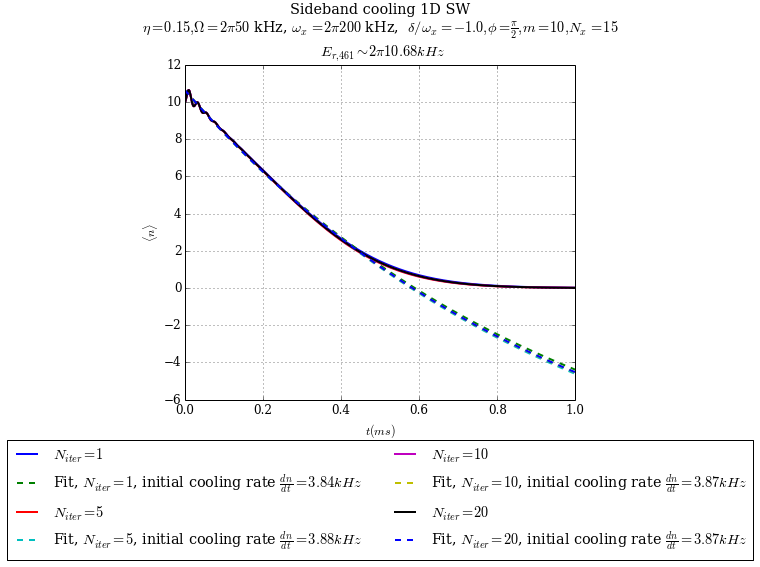

In [30]:
# For running wave the important parameter is the phase 
# Note that cooling can be extremely small for phi = 0 (antinode)
from scipy.optimize import curve_fit

def f(x, a, b, c):
    return a * exp(-2 * pi * b * x) + c 

import timeit
from numpy import linspace, arange, divide, sqrt, exp
from scipy import stats

Nx = 15   # Dimension of x-harmonic oscillator
m = 10
omega_x = 2* pi * 200   # In units of kHz
delta = -2 * pi * 200   # In units of kHz
omega = 2 * pi * 50     # In units of kHz
gamma = 2 * pi * 7      # In units of kHz
eta = 0.15
g = basis(2,0)          # Ground state
e = basis(2,1)          # Excited state
x = fock(Nx, m)         # x-harmonic oscillator
phi = 0.5 * pi

# Recoil energy of the blue
Recoil_461 = (hbar * 2 * pi / (461E-9)) ** 2 / (hbar * 2 * M88 * 1000)
#print(Recoil_461)

# Destruction operators in 1d
a_x = destroy(Nx)

# H_eff / hbar, otherwise too small, too many floats
# Now the two Hamiltonians give different result, I trust the second one
# H = tensor(omega_x * (a_x.dag() * a_x + 0.5), qeye(2)) - tensor(qeye(Nx), 0.5 * delta * sigmaz()) + omega * 0.5 * (tensor((1j * eta * (a_x + a_x.dag())).expm() + (-1j * (eta * (a_x + a_x.dag()) + phi)).expm(), sigmap()) + tensor((-1j * eta * (a_x + a_x.dag())).expm() + (1j * (eta * (a_x + a_x.dag()) + phi)).expm(), sigmam()))
H = tensor(omega_x * (a_x.dag() * a_x + 0.5), qeye(2)) - tensor(qeye(Nx), 0.5 * delta * sigmaz()) + omega * 0.5 * (tensor((1j * (eta * (a_x + a_x.dag()) + phi)).expm() + (-1j * (eta * (a_x + a_x.dag()) + phi)).expm(), sigmax()))

# Wavefunction in 1d, start from all in ground state
psi0 = tensor(x, g)

# Randomly generate u from dipole distribution
du = 0.01
u_ = arange(-1, 1, du)
p = [3 / 8 * (1 + u__) ** 2 for u__ in u_]
p = divide(p, sum(p))
dipole = stats.rv_discrete(name = 'custm', values = (range(len(p)), p))

dt = 1    # Time length
times = linspace(0.0, dt, 1000)
N_iter = [1, 5, 10, 20]
# N_iter = [1, 5]
# N_iter = [1]

import matplotlib.gridspec as gridspec
figure = plt.figure(figsize=(7, 6))
gs = gridspec.GridSpec(1, 1)
gs.update(wspace=0.3,hspace=0.4)
ax1 = plt.subplot(gs[0,0]) 
start = timeit.default_timer()

for N_iter_ in N_iter:
    idx = dipole.rvs(size = N_iter_)
    u = u_[idx]
    q = p[idx]
    q = divide(q, sum(q)) 
    q = sqrt(q)
    print(u, q)
    result = mesolve(H, psi0, times, [sqrt(gamma) * q[i] * tensor((1j * u[i] * eta * (a_x + a_x.dag())).expm(), sigmam()) for i in range(len(u))], [tensor(a_x.dag() * a_x, qeye(2))])
    ax1.plot(result.times, result.expect[0], label = '$N_{iter} = %d$' % (N_iter_), linewidth = 2, linestyle = '-');
    popt, pcov = curve_fit(f, result.times[: 500], result.expect[0][: 500])
    avg_fit = f(times, *popt)
    # print(pcov)
    ax1.plot(times, avg_fit, label = r'Fit, $N_{iter} = %d$, initial cooling rate $\frac{dn}{dt} = %.2f kHz$' % (N_iter_, popt[0] * popt[1]), linewidth = 2, linestyle = '--');
    stop = timeit.default_timer()
    print(stop - start)     # Time spent in seconds
    
ax1.set_xlabel("$t (ms)$")
ax1.set_ylabel(r"$\langle n \rangle$")
#ax1.legend(loc = 1)
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),  ncol = 2)
ax1.set_title('Sideband cooling 1D SW\n'+
           r'$\eta = %.2f, \Omega = 2\pi %d$ kHz, $\omega_x = 2\pi %d$ kHz,  $\delta / \omega_x = %.1f, \phi = \frac{\pi}{2}, m=%d, N_x=%d$' % (eta, omega / (2 * pi), omega_x / (2 * pi), delta / omega_x, m, Nx)
            + '\n $E_{r, 461} \sim 2\pi %.2f kHz$' % (Recoil_461 / (2 * pi)))
ax1.grid(1)
#plt.savefig('Sideband_cooling_1D_RW_1.svg')